In [1]:
import numpy as np

import pandas as pd
import sys, os, time
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append('../')

from src.data_structures import FactorGraph, PriorityQueue
from src.sampling_algorithms.factor_components import (gaussian_bounce, chain_bounce_fn, 
                                                       gaussian_grad_potential_fn, 
                                                       gaussian_chain_grad_potential_fn,
                                                       logistic, 
                                                       generate_logistic_bounce, 
                                                       alias_sample, 
                                                       lambda_r, 
                                                       grad_logistic, 
                                                       lambda_bound
                                                      )
from src.utils import (interp, get_xtv, get_first_moment, get_second_moment, get_var)
from src.sampling_algorithms import LocalBPS
from src.plots.arrow_plot import arrow_plot
from src.utils.serialize import pickle_obj, unpickle_obj, load_json, save_json
from arviz.stats import ess

from matplotlib import rc
rc('text', usetex=False)

In [2]:
np.random.seed(0)
d = 20
T = 100

In [3]:
mu0 = np.array([0. for _ in range(d)])
sig0 = np.diag([1. for _ in range(d)])
mu1 = np.array([0. for _ in range(d)])
sig1 = sig0 + sig0
sig10 = sig0

mus = [np.array([0. for _ in range(d)]) for _ in range(T-1)]
sigs = []     
event_samplers = []
grad_fns = []

for t in range(T):
    if t == 0:
        sigs.append(2*sig0)
        event_samplers.append(chain_bounce_fn(mu1, mu0, sig1, sig0, sig10))
        grad_fns.append(gaussian_chain_grad_potential_fn(mu1, mu0, sig1, sig10, sig0))
    else:
        sigs.append(sigs[t-1]+sig0)
        event_samplers.append(chain_bounce_fn(mu1, mu0, sigs[t], sigs[t-1], sigs[t-1]))
        grad_fns.append(gaussian_chain_grad_potential_fn(mu1, mu0, sigs[t], sigs[t-1], sigs[t-1]))
    
bounce_fns = [gaussian_bounce(mu0, sig0)] + event_samplers

grad_factor_potential_fns = [gaussian_grad_potential_fn(mu0, sig0)] + grad_fns


factor_indices = [[i for i in range(d)]] + \
                 [[d*i +j for j in range(d)]+[d + d*i +j for j in range(d)] for i in range(T)] 

factor_potential_fns = [lambda x: x for _ in grad_factor_potential_fns]

nodes = list(set(n for f in factor_indices for n in f ))


graph = FactorGraph(dim_x=len(nodes),
                  factor_indices=factor_indices,
                  factor_potential_fns=factor_potential_fns,
                  grad_factor_potential_fns=grad_factor_potential_fns)

In [4]:
factor_indices

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59],
 [40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79],
 [60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95

In [5]:
np.random.seed(0)
init_x = np.random.randn(len(nodes))
init_v = np.random.randn(len(nodes))
local_bps = LocalBPS(init_x = init_x,
         init_v = init_v,
         factor_graph = graph,
         bounce_fns=bounce_fns,
         refresh_rate=0.001)

In [6]:
start = time.time()
nsim= 10**5
results = local_bps.simulate(nsim)
res = results
duration = time.time()-start
print(duration)

100%|██████████| 100000/100000 [00:25<00:00, 3904.31it/s]


27.642616748809814


In [7]:
burnin = 10**3
res[burnin:].shape

(99001, 3, 2020)

In [8]:
coef_betas = []
for i in range(len(nodes)):
    x1,v1,t1=get_xtv(res[burnin:],i)
    m = get_first_moment(x1, v1, t1)
    v = get_second_moment(x1, v1, t1)-m**2
    print('M1: {0} M2: {1}'.format(m,np.sqrt(v)))
coef_betas = np.array(coef_betas)

M1: -0.038231784087484344 M2: 1.2090009058662488
M1: 0.2660509922226928 M2: 1.2565108824933828
M1: 0.012502484216672117 M2: 1.1897013633870577
M1: -0.13175002078852222 M2: 1.1038044965685663
M1: -0.24231561898220277 M2: 1.198715823527425
M1: -0.09664187024205108 M2: 1.2393579481224741
M1: 0.011403373479524938 M2: 1.2262401372952063
M1: -0.031650551883261546 M2: 1.137386510633491
M1: -0.0769548248815899 M2: 1.374139615027008
M1: 0.20616880004763394 M2: 1.173918573680547
M1: -0.08044174883120406 M2: 1.30009393420053
M1: 0.148095166057888 M2: 1.1885049780975432
M1: -0.05553932287334837 M2: 1.285572301241868
M1: 0.08101053681764994 M2: 1.158926131514969
M1: -0.06698952898217386 M2: 1.2208203175106487
M1: -0.11094994582603965 M2: 1.1135529946180487
M1: 0.12920798303551206 M2: 1.2397830208771354
M1: 0.08062941709250293 M2: 1.1888839013284045
M1: -0.019603852123759865 M2: 1.3272622669931542
M1: 0.06646390701934707 M2: 1.2489503443792755
M1: -0.11150836730009825 M2: 1.7412779271186432
M1: 0.55

M1: -2.344720881209956 M2: 3.2278978628810746
M1: -1.3887207980859475 M2: 3.2605494443407803
M1: -0.055453220935177176 M2: 3.759958011652219
M1: 0.24556906352321617 M2: 3.396600210680815
M1: -0.37833795010824095 M2: 3.682340534549802
M1: 2.4460900118916546 M2: 2.852075909204998
M1: -0.8167573475951733 M2: 3.1803822793048724
M1: 1.1611147402924247 M2: 2.934729846544646
M1: -0.8777937020382305 M2: 3.1131522992139016
M1: 0.6256413916056311 M2: 3.0245531652493183
M1: -0.30365078507304805 M2: 3.331884832087226
M1: -1.0048428727802645 M2: 3.501901968664043
M1: 1.1356918563736245 M2: 2.9694857262101593
M1: 0.3310940510113306 M2: 2.5154704037362405
M1: 0.39708939038861824 M2: 2.5540513362065353
M1: 0.633574197085521 M2: 2.68331992987864
M1: 0.2688788921534594 M2: 4.098567865398173
M1: 2.7070398262192237 M2: 4.141011310852845
M1: -0.38157723538303245 M2: 2.8919881285880584
M1: -1.406299483374906 M2: 2.8780387924662842
M1: -2.5626937938092023 M2: 3.284571213880246
M1: -1.5527176458371403 M2: 3.2

M1: -0.4072376474733092 M2: 4.773465533474608
M1: 0.6709934630570371 M2: 3.517248621489509
M1: -0.5581357925095396 M2: 4.756444411737937
M1: 4.119420504036585 M2: 3.8439318661160473
M1: -1.334321104606386 M2: 4.406998513556211
M1: 1.5928948016419853 M2: 3.182712838306619
M1: -1.5279164016474758 M2: 3.94824959074713
M1: 1.0073442111131186 M2: 3.6391737863953724
M1: -0.7155690320926009 M2: 3.9497936970386682
M1: -1.4293588495552243 M2: 5.004194458172293
M1: 1.8472447062956416 M2: 3.520188518079603
M1: 0.2941600676122032 M2: 3.0340383743684516
M1: 0.941255016374217 M2: 3.130115942304284
M1: 0.8238985292710173 M2: 3.2335390375095145
M1: 0.8295053919428136 M2: 5.715685412102739
M1: 4.256772347717382 M2: 5.936379768063733
M1: -0.7027887120061644 M2: 3.7300066338388986
M1: -2.1964230764949715 M2: 3.7455904978526453
M1: -3.986657904775868 M2: 3.959885060571986
M1: -2.6832266429128038 M2: 3.4810856604763765
M1: -0.4153642973431954 M2: 4.875742280131878
M1: 0.6365060434993874 M2: 3.5571414963415

M1: -2.188406843180525 M2: 4.835922864616521
M1: 1.6533710132276025 M2: 3.9922224557419157
M1: -1.2588241251902297 M2: 4.501723835361056
M1: -1.9740402698015875 M2: 7.065019650134513
M1: 2.716584304818386 M2: 3.2345956965728937
M1: 0.16353635549021922 M2: 2.992148966093794
M1: 1.540964908905089 M2: 3.861821454104515
M1: 1.1280484027347153 M2: 2.9671217456939187
M1: 1.2540511142920234 M2: 7.811270661711709
M1: 6.587255364296776 M2: 7.849379655359045
M1: -1.1700796386203214 M2: 4.342719349413006
M1: -3.4169630294624307 M2: 4.591934530983473
M1: -6.071083678704671 M2: 4.933128939756487
M1: -3.8276343950291363 M2: 3.2803296675914635
M1: -0.6186238033263636 M2: 5.623065940447675
M1: 0.567360073220734 M2: 3.780207102914587
M1: -1.6412661122284464 M2: 5.123235902186203
M1: 6.164530537710752 M2: 5.350483889089901
M1: -2.180586843822223 M2: 6.097664535156707
M1: 1.9965397302967454 M2: 3.3635477464245795
M1: -2.1965881765923103 M2: 4.905066346218988
M1: 1.7070717050528872 M2: 4.042808549031972
M

M1: 1.5664544903271154 M2: 2.6087431653953117
M1: 1.7066651217624957 M2: 9.45836378034524
M1: 8.318848443289518 M2: 9.149174479858369
M1: -1.3235537987324395 M2: 4.522068742920955
M1: -4.309236073844505 M2: 5.029589876666129
M1: -7.609065482700811 M2: 5.693977398516143
M1: -4.848319169098313 M2: 4.043634247116651
M1: -0.9104215994679409 M2: 5.4961874765018
M1: 0.7647838138908545 M2: 3.9580188439801307
M1: -2.1388418161991316 M2: 5.5664639147493435
M1: 7.420916592309698 M2: 6.5523472084174985
M1: -2.3997029015146993 M2: 7.04048985131149
M1: 2.213024636323801 M2: 3.696713949414421
M1: -2.34417461639718 M2: 5.302193644154321
M1: 2.1289102351061913 M2: 4.48463678643501
M1: -1.7926018332087925 M2: 4.655026538060139
M1: -2.6864696929591854 M2: 8.994824562958794
M1: 3.2364365915313487 M2: 3.8510389644142795
M1: -0.2153785863402655 M2: 3.0088511189231704
M1: 2.383323279622133 M2: 4.382779791343587
M1: 1.584205285436444 M2: 2.496772860211124
M1: 1.7569568275542036 M2: 9.620338254254245
M1: 8.45

M1: -0.6816706055982495 M2: 5.310973178190687
M1: 1.6290230239813526 M2: 3.6242917840608175
M1: -2.598713211386958 M2: 6.6739165632251956
M1: 8.586823913916604 M2: 7.710830084762909
M1: -3.0148393158017517 M2: 8.096214378327238
M1: 2.3366479224057826 M2: 4.096534272445639
M1: -2.2575203234622334 M2: 5.819305380940045
M1: 2.52298993136788 M2: 5.035693575057984
M1: -2.2314847042579333 M2: 4.2722197753434035
M1: -3.30177384776402 M2: 10.76504164862489
M1: 3.776159564420321 M2: 4.7040941876132525
M1: -0.1386472060653563 M2: 2.7085812802871105
M1: 2.9814789969570312 M2: 4.862201542850088
M1: 1.6766790130328215 M2: 2.56013117043515
M1: 2.141344274246568 M2: 11.047823899886849
M1: 10.08091243213715 M2: 10.044401779498685
M1: -1.5558997267812584 M2: 4.538900705566175
M1: -5.1893395890739225 M2: 5.739116329446109
M1: -8.86878692326785 M2: 6.749179752204155
M1: -6.1086838931670755 M2: 4.64637106769829
M1: -0.6765629344691877 M2: 5.214168187388216
M1: 1.7332211856199347 M2: 3.6189351194373476
M1:

M1: 2.0240746084655115 M2: 3.6904703242714123
M1: -3.0463317058227157 M2: 7.526269149422378
M1: 9.527675916738795 M2: 8.60019387831812
M1: -3.3190158224650315 M2: 8.957201787844394
M1: 2.6810102178300665 M2: 4.467267806494862
M1: -2.2137464055964386 M2: 6.4746563569617
M1: 2.9164833462712716 M2: 5.607969315904828
M1: -2.6229723390864055 M2: 3.6985284766951443
M1: -3.65821590023363 M2: 11.910508962688107
M1: 4.418669253450601 M2: 5.363529964989421
M1: 0.22010058831387508 M2: 2.4362717623237162
M1: 3.4569011258454494 M2: 4.77887848886541
M1: 1.7506872893749916 M2: 2.8443849477356724
M1: 2.618337129363372 M2: 12.072251373161693
M1: 11.37666755242019 M2: 11.012224849332627
M1: -1.539096881998074 M2: 4.262718226308906
M1: -5.467858324549892 M2: 6.291001172296587
M1: -9.96906839535822 M2: 7.124551755686191
M1: -7.061658992283401 M2: 4.906987953728472
M1: -0.21546182751062315 M2: 4.7679078318208195
M1: 2.031250313764846 M2: 3.659324459954198
M1: -3.12699872784338 M2: 7.5928380488066045
M1: 9.

M1: 3.7957808029619544 M2: 5.814069787864889
M1: -2.8938561415035644 M2: 3.2335803704584927
M1: -4.624935976175485 M2: 13.104055793084393
M1: 4.919540428178351 M2: 5.542619436152411
M1: 0.41286369397804784 M2: 2.6218302449539475
M1: 4.076271808008758 M2: 4.968463768908609
M1: 1.8336317360888783 M2: 3.3114399544313997
M1: 3.059222908753863 M2: 13.03195875345225
M1: 12.65825673418596 M2: 11.902365613976267
M1: -1.2524582570709875 M2: 4.219259999991562
M1: -5.794121609153768 M2: 6.893801770196429
M1: -11.341018110454806 M2: 7.5726409908365335
M1: -7.913451634830658 M2: 5.30663849288951
M1: 0.252017744495925 M2: 4.659134259502829
M1: 1.9526876323688231 M2: 3.643528602743256
M1: -3.3244867514545944 M2: 8.327368096717288
M1: 10.479656089806138 M2: 9.457115254245299
M1: -3.9275261618657042 M2: 9.950598996828843
M1: 3.025473602122529 M2: 4.324142705730922
M1: -2.4784519988339366 M2: 7.036043094866241
M1: 3.8732967299659724 M2: 5.830824689946719
M1: -2.9535819249583257 M2: 3.201039466757171
M1:

M1: 4.469080883653626 M2: 4.689328402773266
M1: 1.797316224142013 M2: 2.8062755343879853
M1: 3.4954801815248495 M2: 13.792147141820465
M1: 13.727656865542857 M2: 12.744618500651963
M1: -1.123727290350284 M2: 4.061541495448377
M1: -6.161520467941986 M2: 7.479205554281104
M1: -12.566365100514279 M2: 7.600502578586869
M1: -8.912236150119648 M2: 5.4693270480522616
M1: 0.5616158545947143 M2: 5.074450772453343
M1: 2.109428796262187 M2: 3.4770413690187234
M1: -3.3389047129756633 M2: 8.854877864027506
M1: 11.259837113786544 M2: 10.508741404571433
M1: -4.4904595222308155 M2: 10.506190502690234
M1: 3.0548484073382474 M2: 4.961256825602679
M1: -2.6541112635358113 M2: 7.587596008650047
M1: 4.362027271535043 M2: 5.868485768344979
M1: -3.4357024346341323 M2: 3.2760985216650114
M1: -5.267940589545228 M2: 13.861735921027867
M1: 5.362517763775929 M2: 5.662665423468384
M1: 0.4672938030544963 M2: 3.3403664118875156
M1: 4.473754944603389 M2: 4.691915533719539
M1: 1.7570280204570323 M2: 2.709366319638251
M

M1: -6.363698314300205 M2: 7.533379578173871
M1: -13.46567228739649 M2: 7.365372916580864
M1: -9.502455104873983 M2: 5.722734881427322
M1: 0.7160767240657258 M2: 5.521105688153963
M1: 2.210659816995645 M2: 3.676459325475922
M1: -3.287870125157886 M2: 9.366175891177155
M1: 11.579426637422827 M2: 11.361829869714404
M1: -4.6808076061392665 M2: 10.762700626545312
M1: 3.03667038044286 M2: 5.309979137056732
M1: -2.7976563480159675 M2: 8.226846480331695
M1: 4.747500842600548 M2: 6.041962056744039
M1: -3.8098335703734474 M2: 3.847542913315886
M1: -5.734728961572097 M2: 14.174542850488427
M1: 5.518909317923888 M2: 5.262648916519653
M1: 0.33470815371947915 M2: 3.549140930251431
M1: 4.232788171374186 M2: 4.469911734013736
M1: 1.9099694235085458 M2: 2.809978152348017
M1: 3.5413995967350598 M2: 14.58262248366104
M1: 14.224105869738404 M2: 13.507732059420386
M1: -1.0286938323875912 M2: 4.618051805229389
M1: -6.40981014264395 M2: 7.599087888528888
M1: -13.556437596260066 M2: 7.38027089717597
M1: -9.5

M1: -4.887015649906753 M2: 11.141843342327242
M1: 3.033413018635438 M2: 5.747470315969134
M1: -2.8646532203506356 M2: 8.894893288455936
M1: 4.886427796850581 M2: 6.270728836463643
M1: -4.042629439105952 M2: 4.242319402752311
M1: -6.0329372053971335 M2: 14.373261675625582
M1: 5.458199175236568 M2: 5.352039221523695
M1: 0.0698175201246817 M2: 4.037613010520007
M1: 4.240408348083375 M2: 4.070356860739036
M1: 1.9780872431511811 M2: 3.28006877643372
M1: 3.7832512153102735 M2: 15.065037579126054
M1: 14.700083359763825 M2: 14.168095609523618
M1: -0.9709891713026347 M2: 4.942709901174363
M1: -6.725055927289633 M2: 7.896028577427291
M1: -14.351088676694784 M2: 7.232363717976396
M1: -10.23126531805376 M2: 6.182992965886811
M1: 1.015064621815852 M2: 6.133335959735985
M1: 2.1300403537972152 M2: 4.0025089812628
M1: -3.1502910172509124 M2: 10.250094391154263
M1: 11.737088825226085 M2: 12.137514443397045
M1: -4.873370354801593 M2: 11.209674402907293
M1: 3.048450530298745 M2: 5.836037753346777
M1: -2.

In [9]:

start = time.time()
nsim= 10**5
results = local_bps.simulate(nsim)
res = results
duration = time.time()-start
print(duration)

m = min(len(nodes),100)
esses = []
for i in range(m):
    x1,v1,t1=get_xtv(res,i)
    x = interp(x1,t1,v1, num_intervals=nsim*5)
    e = ess(x, method='bulk')
    esses.append(e)

ess_speed = np.mean(esses)/duration

ess_speed.item()

ESS bulk: 3.6053790527948397
ESS tail: 8.07547083513141
ESS bulk: 5.7265228146048415
ESS tail: 8.730922837921561
ESS bulk: 5.780011841640582
ESS tail: 9.543182050311191
ESS bulk: 4.7758601066550606
ESS tail: 7.833452779445054
ESS bulk: 5.352840070091516
ESS tail: 8.738350667240937
ESS bulk: 5.154466904558957
ESS tail: 7.349299735555802
ESS bulk: 4.976189334257088
ESS tail: 7.701737782711984
ESS bulk: 4.844052094238429
ESS tail: 7.208715509369759
ESS bulk: 5.3733357771109835
ESS tail: 7.884681858024462
ESS bulk: 5.460085079150279
ESS tail: 10.044380487127267
ESS bulk: 5.336440474401462
ESS tail: 7.237993900051262
ESS bulk: 4.913541705290688
ESS tail: 5.135065367943883
ESS bulk: 5.022689086923119
ESS tail: 7.888680011427548
ESS bulk: 5.071477244441486
ESS tail: 7.621192914715512
ESS bulk: 5.449804060341678
ESS tail: 9.034334699259219
ESS bulk: 5.424163842900533
ESS tail: 7.839841158774416
ESS bulk: 5.673064715201529
ESS tail: 11.258947199613024
ESS bulk: 5.516118328215361
ESS tail: 7.199

In [11]:
pickle_obj(ess_speed.item(), 'ess_res_d_{0}_T_{1}_{2}.pkl'.format(d,T,'local'))

In [12]:
unpickle_obj('ess_res_d_{0}_T_{1}_{2}.pkl'.format(d,T,'local'))

2.6331290281305684

In [13]:
x1,v1,t1=get_xtv(res,0)
x2,v2,t2=get_xtv(res,1)

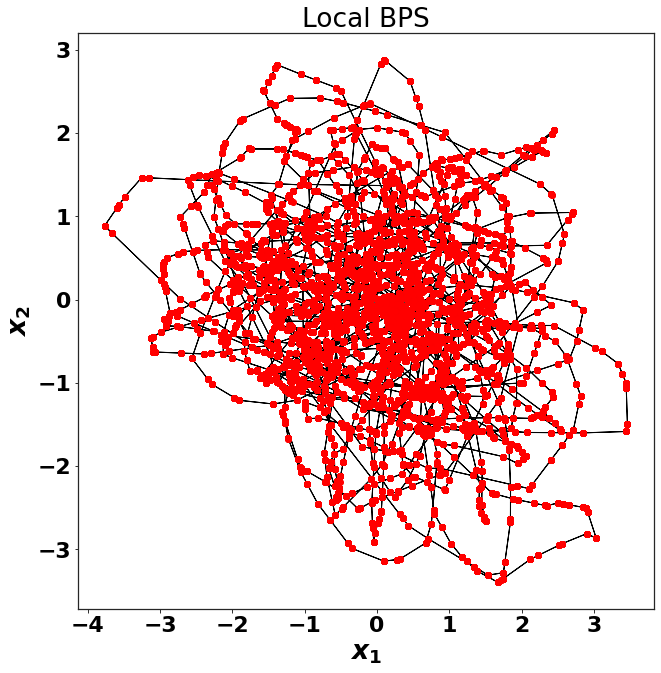

In [14]:
x1,v1,t1=get_xtv(res,2)
x2,v2,t2=get_xtv(res,3)
burnin = 4000
plot_limit = 100000
fig_size = (10,10)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

fig = plt.figure(figsize=fig_size,frameon =True)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
ax.set_title("Local BPS")
ax.set_xlabel("$x_1$",fontsize='large', fontweight='bold')
ax.set_ylabel("$x_2$",fontsize='large', fontweight='bold')
arrow_plot(x1[burnin:burnin+plot_limit],x2[burnin:burnin+plot_limit], head_length=0.01,head_width=0.01)
fig.savefig('./local_bps.eps', format='eps', dpi=1200)



In [22]:
del results

In [29]:
globals()['x1']

array([-0.68881002, -0.68881002, -0.68881002, ...,  1.51830591,
        1.51830591,  1.51830591])